In [6]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(pheatmap)

In [56]:
#-------------------------------------------
#TODO 绘制同源基因，exon长度差异信息
#-------------------------------------------
plotData=read.table("./Homoeologous_ExonData.txt",header = T,sep="\t")
plotData$difflevel=as.integer(as.character(as.vector(cut(
    plotData$ExonLengthDifference,
    c(-Inf, 0, 10, 20, 30, 40, 50, 60, 80, 100, 150, 200, 250, 300,400,500,700,1000,Inf),
    labels = seq(1, 18, 1),
    right = F
))))
#* 这里labels为2时，表示区间范围为[0-10)

In [43]:
plotData %>% filter(ExonLengthDifference<=10) %>% count(difflevel)

difflevel,n
<int>,<int>
2,1711
3,76


In [72]:
seq(2,18,1)

[1]  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18

png 
  2

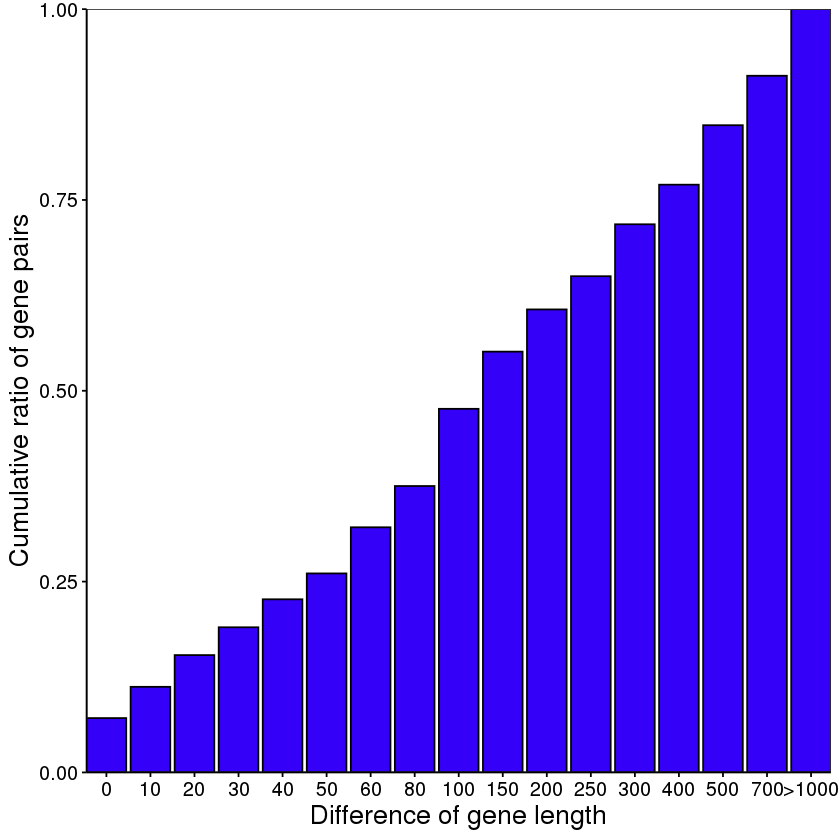

In [79]:
#* 绘制累积分布密度图
p=plotData %>%
    count(difflevel) %>%
    mutate(cumCount = cumsum(n)) %>%
    ggplot(
        aes(x = difflevel, y = cumCount / 24038)
    )+geom_bar(
        stat='identity',
        fill='#3500f8',
        color='black'
        )+
    theme_bw()+
    theme(
        panel.background = element_blank(),
        panel.grid = element_blank()
    )+
    scale_x_continuous(
        expand = c(0,0),
        breaks = seq(2,18,1),
        labels = c(
           0,10, 20, 30, 40, 50, 60, 80, 100, 150, 200, 250, 300,400,500,700,'>1000'
        )
        )+
    base_theme+
    scale_y_continuous(expand = c(0,0))+
    ylab("Cumulative ratio of gene pairs")+
    xlab("Difference of gene length")

pdf("Difference_exon_length.pdf")
print(p)
dev.off()
p

In [11]:
head(plotData)

,genePair,AtExonCount,DtExonCount,AtLength,DtLength,ExonNumberDifference,ExonLengthDifference
,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,Ghir_A01G000040-Ghir_D01G000060,2,2,2416,2850,0,434
2,Ghir_A01G000070-Ghir_D01G000110,7,7,2978,2857,0,121
3,Ghir_A01G000080-Ghir_D01G000100,1,1,1445,1453,0,8
4,Ghir_A01G000100-Ghir_D01G000120,10,10,1239,1266,0,27
5,Ghir_A01G000110-Ghir_D01G000130,2,2,744,738,0,6
6,Ghir_A01G000130-Ghir_D01G000150,5,6,1115,462,1,653


In [2]:
#-----------------------------------------------
#TODO 读取根据FPKM定义的样本Bias情况，进行聚类分析
#-----------------------------------------------
FPKM_BiasType=read.table("./12DPA_BiasType_Sample_FPKM.txt",header=T,row.names = 1,sep="\t")

In [3]:
#--------------------------------------------------
#TODO 根据每个样本中Bias的基因数目进行层次聚类
#! 宽转长
#? 长转宽
#--------------------------------------------------

FPKM_BiasType_long=FPKM_BiasType %>% pivot_longer(
    cols=starts_with('S'),
    names_to = 'sample',
    values_to = 'Biastype'
)
sampleBiasData=FPKM_BiasType_long %>% group_by(sample) %>% count(Biastype)
sampleBiasData=pivot_wider(sampleBiasData,id_cols ='sample',names_from = 'Biastype',values_from = 'n' ) 
colnames(sampleBiasData)=c('sample','BiasD','BiasN','BiasA')

In [4]:
#* 计算不同样本之间的相关系数矩阵，绘制pheatmap
BiasType_cor=cor( FPKM_BiasType)

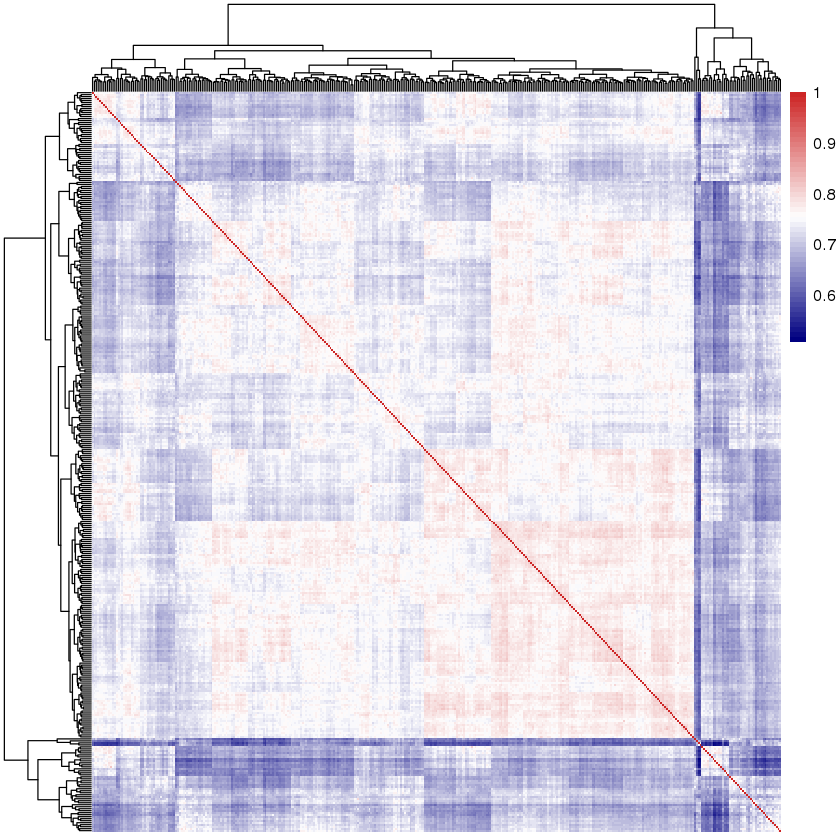

In [5]:
p=pheatmap(
    BiasType_cor,
    cluster_rows = T,
    cluster_cols = T,
    show_rownames = F,
    show_colnames = F,
    color = colorRampPalette(c("navy", "white", "firebrick3"))(50)
)

In [6]:
pdf("sampleCor_FPKM.pdf")
print(p)
dev.off()

png 
  2

In [7]:
#-----------------------------------------------------------------
#TODO: 按照基因read Count的数据
#? 聚类结果
#-----------------------------------------------------------------
reads_BiasType=read.table("./12DPA_BiasType_Sample_readCount.txt",header=T,row.names = 1,sep="\t") 
BiasType_reads_cor=cor(reads_BiasType)

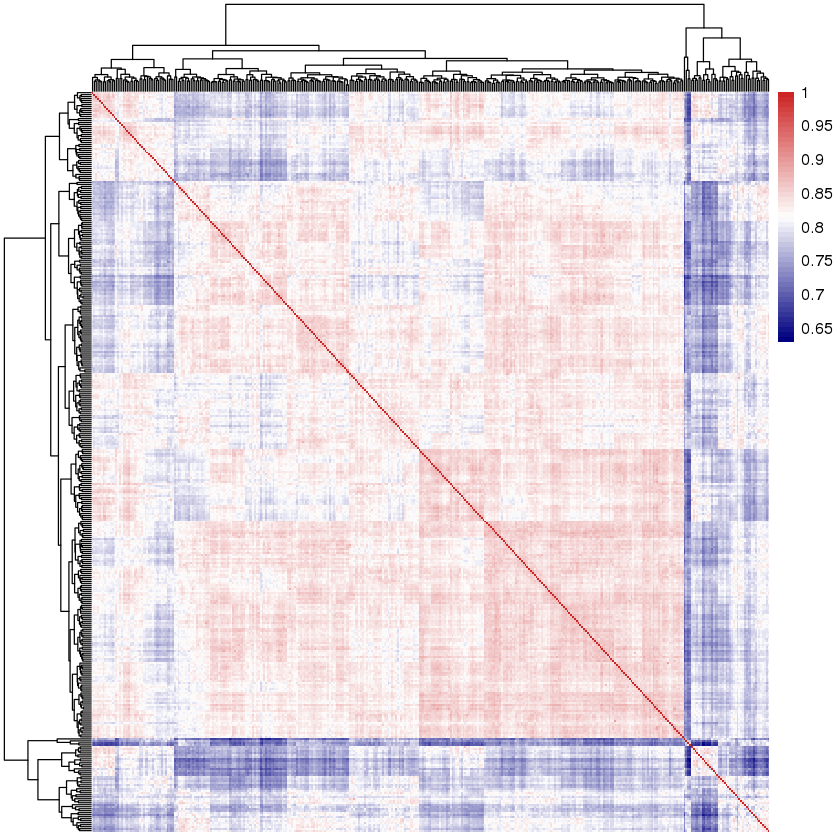

In [8]:
p2=pheatmap(
    BiasType_reads_cor,
    cluster_rows = p$tree_row,
    cluster_cols = p$tree_col,
    show_rownames = F,
    show_colnames = F,
    color = colorRampPalette(c("navy", "white", "firebrick3"))(50)
)

In [9]:
pdf("sampleCor_readCount.pdf")
print(p2)
dev.off()

png 
  2

In [2]:
library(flexclust)

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [10]:

#------------------------------
#TODO 计算rand index
#------------------------------
randIndexData=c()
for (clusterID in seq(2,20,1)){
    cluster_FPKM=kmeans(BiasType_cor, centers = clusterID, iter.max = 50000)
    cluster_reads=kmeans(BiasType_reads_cor, centers = clusterID, iter.max = 50000)
    randIndexRatio=randIndex(table(cluster_FPKM$cluster,cluster_reads$cluster),correct = F)
    randIndexData=rbind(
        randIndexData,c(clusterID,randIndexRatio)
    )
}

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [15]:
data.frame(randIndexData) %>% summarise(mean(RI))

mean(RI)
<dbl>
0.8852964


In [25]:
#----------------------------------------------------------
# TODO 统计每个基因在两种方法之间的兰德指数
#----------------------------------------------------------
stageArray=data.frame(
    stage=c('test'),
    meanVal=c(2),
    minVal=c(3),
    maxVal=c(4)
)
for (stage in c("0DPA", "4DPA", "8DPA", "12DPA", "16DPA", "20DPA"))
{
    RIarray <- c()
    FPKM_BiasType <- read.table(paste(stage, "/", stage, "_BiasType_Sample_FPKM.txt", sep = ""), header = T, row.names = 1, sep = "\t")
    reads_BiasType <- read.table(paste(stage, "/", stage, "_BiasType_Sample_readCount.txt", sep = ""), header = T, row.names = 1, sep = "\t")
    commonSample <- intersect(colnames(reads_BiasType), colnames(FPKM_BiasType))
    FPKM_BiasType <- FPKM_BiasType %>% select(as.vector(commonSample))
    reads_BiasType <- reads_BiasType %>% select(as.vector(commonSample))
    for (genePair in rownames(reads_BiasType)) {
        readCount <- reads_BiasType[genePair, ]
        FpkmCount <- FPKM_BiasType[genePair, ]
        RIindex <- randIndex(table(readCount, FpkmCount), correct = F)
        RIarray <- c(RIarray, RIindex)
        break 
    }
    print(paste(stage, mean(RIarray), min(RIarray), max(RIarray), sep = "--"))
    stageArray=rbind(stageArray,list(stage, mean(RIarray), min(RIarray), max(RIarray)))
    break
}
print(stageArray)
write.table(stageArray,"geneRandIndex.txt",col.names =T,row.names = F,quote = F,sep="\t")

[1] "0DPA--0.666359041968798--0.666359041968798--0.666359041968798"


In [23]:
length(RIarray)

[1] 12783

In [21]:
print(paste(stage, mean(RIarray), min(RIarray), max(RIarray), sep = "--"))

[1] "8DPA--0.812307178424276--0.338159000666609--1"


In [17]:
mean(RIarray)
min(RIarray)
max(RIarray)

[1] 0.7990117

[1] 0.3316675

[1] 1